In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_141520/3956026877.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-22 08:20:09.722101: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 08:20:09.764425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 08:2

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all=hf.add_MSI_noise(data_all,channel_labels)

Noise standard deviation for Cloud_B02: 0.047201970817249306
Noise standard deviation for Cloud_B03: 0.04324797895910738
Noise standard deviation for Cloud_B04: 0.053827043290068204
Noise standard deviation for Cloud_B05: 0.05789661194884042
Noise standard deviation for Cloud_B06: 0.07629055723729171
Noise standard deviation for Cloud_B07: 0.09610053927638564
Noise standard deviation for Cloud_B08: 0.21390416701316764
Noise standard deviation for Cloud_B09: 0.07990014621152891
Noise standard deviation for Cloud_B10: 0.049563194143074654
Noise standard deviation for Cloud_B11: 0.018083165644110548
Noise standard deviation for Cloud_B12: 0.065263563505515
Noise standard deviation for Cloud_B13: 0.05174227777279204


In [4]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

X_truth=df_truth[X_labels]

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

(array([ 8880., 15889., 73025., 91676.,  6759.,  1508.,  1386.,   590.,
          163.,   124.]),
 array([0.04146 , 0.330892, 0.620324, 0.909756, 1.199188, 1.48862 ,
        1.778052, 2.067484, 2.356916, 2.646348, 2.93578 ]),
 <BarContainer object of 10 artists>)

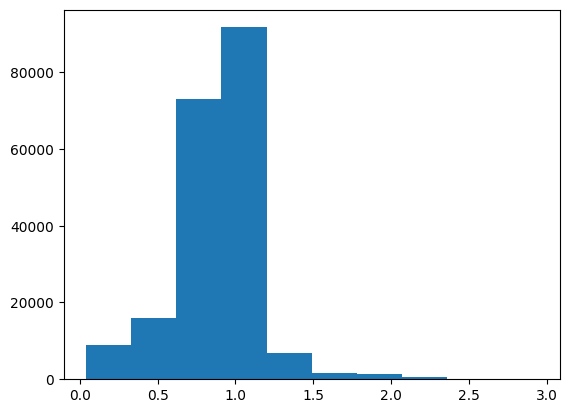

In [18]:
plt.hist(df_truth['Clear_B12'])

In [19]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500

In [20]:
nepochs=200

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(len(X_labels),256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


Batch number: 100%|██████████| 361/361 [00:01<00:00, 282.11it/s]

Training loss [0.91417676] Validation loss [0.6308818]
----New best validation loss---- [0.6308818]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:00<00:00, 511.73it/s]


Training loss [0.5961863] Validation loss [0.55724543]
----New best validation loss---- [0.55724543]
Epoch 3


Batch number: 100%|██████████| 361/361 [00:00<00:00, 529.23it/s]

Training loss [0.53988594] Validation loss [0.5254125]
----New best validation loss---- [0.5254125]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:00<00:00, 458.56it/s]

Training loss [0.50630677] Validation loss [0.4962989]
----New best validation loss---- [0.4962989]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.19it/s]


Training loss [0.48627093] Validation loss [0.4756412]
----New best validation loss---- [0.4756412]
Epoch 6


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.53it/s]


Training loss [0.467792] Validation loss [0.46549428]
----New best validation loss---- [0.46549428]
Epoch 7


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.58it/s]


Training loss [0.457206] Validation loss [0.46591935]
Epoch 8


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.28it/s]


Training loss [0.44772527] Validation loss [0.44035977]
----New best validation loss---- [0.44035977]
Epoch 9


Batch number: 100%|██████████| 361/361 [00:00<00:00, 363.96it/s]

Training loss [0.4393138] Validation loss [0.43322393]
----New best validation loss---- [0.43322393]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 373.46it/s]

Training loss [0.43223384] Validation loss [0.4303829]
----New best validation loss---- [0.4303829]
Epoch 11



Batch number: 100%|██████████| 361/361 [00:00<00:00, 457.73it/s]

Training loss [0.427749] Validation loss [0.42415816]
----New best validation loss---- [0.42415816]
Epoch 12



Batch number: 100%|██████████| 361/361 [00:00<00:00, 419.39it/s]

Training loss [0.42335248] Validation loss [0.41685626]
----New best validation loss---- [0.41685626]
Epoch 13



Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.96it/s]


Training loss [0.41823813] Validation loss [0.41408214]
----New best validation loss---- [0.41408214]
Epoch 14


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.07it/s]


Training loss [0.41434833] Validation loss [0.41615778]
Epoch 15


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.76it/s]


Training loss [0.41196144] Validation loss [0.40729865]
----New best validation loss---- [0.40729865]
Epoch 16


Batch number: 100%|██████████| 361/361 [00:00<00:00, 533.82it/s]

Training loss [0.4076028] Validation loss [0.40790844]
Epoch 17



Batch number: 100%|██████████| 361/361 [00:00<00:00, 543.18it/s]

Training loss [0.40511426] Validation loss [0.41187984]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.02it/s]


Training loss [0.4020283] Validation loss [0.40270185]
----New best validation loss---- [0.40270185]
Epoch 19


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.01it/s]


Training loss [0.4004611] Validation loss [0.40246984]
----New best validation loss---- [0.40246984]
Epoch 20


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.67it/s]


Training loss [0.3978518] Validation loss [0.3958937]
----New best validation loss---- [0.3958937]
Epoch 21


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.40it/s]


Training loss [0.3951296] Validation loss [0.38987562]
----New best validation loss---- [0.38987562]
Epoch 22


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.81it/s]


Training loss [0.393989] Validation loss [0.39417088]
Epoch 23


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.45it/s]


Training loss [0.39096236] Validation loss [0.3945356]
Epoch 24


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.69it/s]


Training loss [0.38980603] Validation loss [0.38365287]
----New best validation loss---- [0.38365287]
Epoch 25


Batch number: 100%|██████████| 361/361 [00:00<00:00, 549.73it/s]

Training loss [0.3875241] Validation loss [0.3863461]
Epoch 26



Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.94it/s]


Training loss [0.38551262] Validation loss [0.38494465]
Epoch 27


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.48it/s]


Training loss [0.385606] Validation loss [0.38731158]
Epoch 28


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.22it/s]


Training loss [0.38398004] Validation loss [0.38426068]
Epoch 29


Batch number: 100%|██████████| 361/361 [00:00<00:00, 534.65it/s]

Training loss [0.38201627] Validation loss [0.3792629]
----New best validation loss---- [0.3792629]
Epoch 30



Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.15it/s]

Training loss [0.38000873] Validation loss [0.3822371]
Epoch 31



Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.87it/s]


Training loss [0.3795276] Validation loss [0.3873717]
Epoch 32


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.21it/s]


Training loss [0.37812293] Validation loss [0.38020465]
Epoch 33


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.66it/s]


Training loss [0.37639335] Validation loss [0.37710834]
----New best validation loss---- [0.37710834]
Epoch 34


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.62it/s]


Training loss [0.37615296] Validation loss [0.37911057]
Epoch 35


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.37it/s]


Training loss [0.3759241] Validation loss [0.37998936]
Epoch 36


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.39it/s]


Training loss [0.3735151] Validation loss [0.37650356]
----New best validation loss---- [0.37650356]
Epoch 37


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.97it/s]


Training loss [0.3730909] Validation loss [0.3749778]
----New best validation loss---- [0.3749778]
Epoch 38


Batch number: 100%|██████████| 361/361 [00:00<00:00, 527.51it/s]

Training loss [0.37198475] Validation loss [0.368301]
----New best validation loss---- [0.368301]
Epoch 39



Batch number: 100%|██████████| 361/361 [00:00<00:00, 607.73it/s]


Training loss [0.37117207] Validation loss [0.37908176]
Epoch 40


Batch number: 100%|██████████| 361/361 [00:00<00:00, 372.82it/s]

Training loss [0.37076893] Validation loss [0.3689409]
Epoch 41



Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.47it/s]

Training loss [0.37005457] Validation loss [0.38640088]
Epoch 42



Batch number: 100%|██████████| 361/361 [00:01<00:00, 350.39it/s]

Training loss [0.3683806] Validation loss [0.37011045]
Epoch 43



Batch number: 100%|██████████| 361/361 [00:00<00:00, 362.54it/s]

Training loss [0.36763456] Validation loss [0.37165058]
Epoch 44



Batch number: 100%|██████████| 361/361 [00:01<00:00, 350.71it/s]


Training loss [0.3673412] Validation loss [0.3670016]
----New best validation loss---- [0.3670016]
Epoch 45


Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.21it/s]

Training loss [0.36592174] Validation loss [0.36731717]
Epoch 46



Batch number: 100%|██████████| 361/361 [00:01<00:00, 350.35it/s]

Training loss [0.36537707] Validation loss [0.37184677]
Epoch 47



Batch number: 100%|██████████| 361/361 [00:00<00:00, 364.01it/s]

Training loss [0.36508107] Validation loss [0.36486676]
----New best validation loss---- [0.36486676]
Epoch 48



Batch number: 100%|██████████| 361/361 [00:00<00:00, 533.17it/s]

Training loss [0.36370698] Validation loss [0.3699866]
Epoch 49



Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.63it/s]


Training loss [0.36372602] Validation loss [0.37124273]
Epoch 50


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.60it/s]


Training loss [0.36275125] Validation loss [0.3611852]
----New best validation loss---- [0.3611852]
Epoch 51


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.06it/s]


Training loss [0.3616897] Validation loss [0.36838147]
Epoch 52


Batch number: 100%|██████████| 361/361 [00:00<00:00, 528.50it/s]

Training loss [0.36231616] Validation loss [0.35959706]
----New best validation loss---- [0.35959706]
Epoch 53



Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.35it/s]


Training loss [0.3603586] Validation loss [0.36529976]
Epoch 54


Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.88it/s]

Training loss [0.35995632] Validation loss [0.3567147]
----New best validation loss---- [0.3567147]
Epoch 55



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.32it/s]

Training loss [0.35931423] Validation loss [0.3579481]
Epoch 56



Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.19it/s]

Training loss [0.35913697] Validation loss [0.3586004]
Epoch 57



Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.11it/s]

Training loss [0.35796726] Validation loss [0.36418933]
Epoch 58



Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.19it/s]

Training loss [0.35746843] Validation loss [0.36057067]


Epoch 59


Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.21it/s]

Training loss [0.35739365] Validation loss [0.35912904]
Epoch 60



Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.49it/s]

Training loss [0.35700378] Validation loss [0.35772678]
Epoch 61



Batch number: 100%|██████████| 361/361 [00:00<00:00, 573.50it/s]

Training loss [0.35598403] Validation loss [0.36076993]
Epoch 62



Batch number: 100%|██████████| 361/361 [00:00<00:00, 573.53it/s]

Training loss [0.3562698] Validation loss [0.358564]
Epoch 63



Batch number: 100%|██████████| 361/361 [00:00<00:00, 574.26it/s]

Training loss [0.3541821] Validation loss [0.35758287]
Epoch 64



Batch number: 100%|██████████| 361/361 [00:00<00:00, 573.72it/s]

Training loss [0.3544884] Validation loss [0.35871613]
Epoch 65



Batch number: 100%|██████████| 361/361 [00:00<00:00, 573.13it/s]

Training loss [0.3528848] Validation loss [0.35721436]
Epoch 66



Batch number: 100%|██████████| 361/361 [00:00<00:00, 574.99it/s]

Training loss [0.35332426] Validation loss [0.3542466]
----New best validation loss---- [0.3542466]
Epoch 67



Batch number: 100%|██████████| 361/361 [00:00<00:00, 380.76it/s]

Training loss [0.35206717] Validation loss [0.35818794]
Epoch 68



Batch number: 100%|██████████| 361/361 [00:01<00:00, 342.40it/s]

Training loss [0.3523697] Validation loss [0.3584486]
Epoch 69



Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.11it/s]


Training loss [0.3510376] Validation loss [0.35270962]
----New best validation loss---- [0.35270962]
Epoch 70


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.29it/s]


Training loss [0.35087886] Validation loss [0.35335296]
Epoch 71


Batch number: 100%|██████████| 361/361 [00:00<00:00, 405.61it/s]

Training loss [0.35017988] Validation loss [0.35161808]
----New best validation loss---- [0.35161808]
Epoch 72



Batch number: 100%|██████████| 361/361 [00:01<00:00, 354.07it/s]


Training loss [0.34948146] Validation loss [0.3508989]
----New best validation loss---- [0.3508989]
Epoch 73


Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.59it/s]

Training loss [0.34985468] Validation loss [0.35849744]
Epoch 74



Batch number: 100%|██████████| 361/361 [00:01<00:00, 344.42it/s]

Training loss [0.34910706] Validation loss [0.35328552]
Epoch 75



Batch number: 100%|██████████| 361/361 [00:01<00:00, 350.29it/s]

Training loss [0.34879735] Validation loss [0.35205224]
Epoch 76



Batch number: 100%|██████████| 361/361 [00:01<00:00, 341.27it/s]

Training loss [0.3481203] Validation loss [0.35157704]
Epoch 77



Batch number: 100%|██████████| 361/361 [00:01<00:00, 343.67it/s]

Training loss [0.34814584] Validation loss [0.35336825]
Epoch 78



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.02it/s]

Training loss [0.34700543] Validation loss [0.35091114]
Epoch 79



Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.11it/s]


Training loss [0.34818423] Validation loss [0.34906608]
----New best validation loss---- [0.34906608]
Epoch 80


Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.09it/s]


Training loss [0.34615657] Validation loss [0.34910423]
Epoch 81


Batch number: 100%|██████████| 361/361 [00:00<00:00, 404.16it/s]


Training loss [0.345967] Validation loss [0.34984562]
Epoch 82


Batch number: 100%|██████████| 361/361 [00:01<00:00, 347.63it/s]

Training loss [0.34573045] Validation loss [0.34659222]
----New best validation loss---- [0.34659222]
Epoch 83



Batch number: 100%|██████████| 361/361 [00:00<00:00, 364.91it/s]

Training loss [0.34509736] Validation loss [0.34555134]
----New best validation loss---- [0.34555134]
Epoch 84



Batch number: 100%|██████████| 361/361 [00:00<00:00, 420.10it/s]

Training loss [0.34527406] Validation loss [0.35277742]
Epoch 85



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.93it/s]

Training loss [0.34424323] Validation loss [0.34351653]
----New best validation loss---- [0.34351653]
Epoch 86



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.37it/s]

Training loss [0.34491786] Validation loss [0.35213977]
Epoch 87



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.34it/s]

Training loss [0.34464958] Validation loss [0.345713]
Epoch 88



Batch number: 100%|██████████| 361/361 [00:00<00:00, 408.83it/s]

Training loss [0.34328687] Validation loss [0.34949538]
Epoch 89



Batch number: 100%|██████████| 361/361 [00:00<00:00, 364.22it/s]

Training loss [0.3432759] Validation loss [0.3495623]
Epoch 90



Batch number: 100%|██████████| 361/361 [00:00<00:00, 527.59it/s]

Training loss [0.34333333] Validation loss [0.348132]
Epoch 91



Batch number: 100%|██████████| 361/361 [00:01<00:00, 351.50it/s]

Training loss [0.34386516] Validation loss [0.3522147]
Epoch 92



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.26it/s]


Training loss [0.34180176] Validation loss [0.34951282]
Epoch 93


Batch number: 100%|██████████| 361/361 [00:00<00:00, 523.49it/s]

Training loss [0.34167406] Validation loss [0.34250236]
----New best validation loss---- [0.34250236]
Epoch 94



Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.20it/s]


Training loss [0.34142712] Validation loss [0.3463443]
Epoch 95


Batch number: 100%|██████████| 361/361 [00:00<00:00, 532.12it/s]

Training loss [0.34210724] Validation loss [0.34331405]
Epoch 96



Batch number: 100%|██████████| 361/361 [00:00<00:00, 496.98it/s]

Training loss [0.34080943] Validation loss [0.34511933]
Epoch 97



Batch number: 100%|██████████| 361/361 [00:01<00:00, 347.19it/s]

Training loss [0.34115192] Validation loss [0.34357235]
Epoch 98



Batch number: 100%|██████████| 361/361 [00:01<00:00, 360.05it/s]

Training loss [0.3402422] Validation loss [0.3455893]
Epoch 99



Batch number: 100%|██████████| 361/361 [00:01<00:00, 342.01it/s]

Training loss [0.33895713] Validation loss [0.3455732]
Epoch 100



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.59it/s]

Training loss [0.33991334] Validation loss [0.3443236]
Epoch 101



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.98it/s]

Training loss [0.33960643] Validation loss [0.3442875]
Epoch 102



Batch number: 100%|██████████| 361/361 [00:00<00:00, 392.39it/s]

Training loss [0.33960235] Validation loss [0.34601724]
Epoch 103



Batch number: 100%|██████████| 361/361 [00:00<00:00, 363.32it/s]

Training loss [0.33870855] Validation loss [0.34888908]
Epoch 104



Batch number: 100%|██████████| 361/361 [00:01<00:00, 344.94it/s]

Training loss [0.3391044] Validation loss [0.33996364]
----New best validation loss---- [0.33996364]
Epoch 105



Batch number: 100%|██████████| 361/361 [00:01<00:00, 360.80it/s]

Training loss [0.33842725] Validation loss [0.3471897]
Epoch 106



Batch number: 100%|██████████| 361/361 [00:00<00:00, 385.90it/s]

Training loss [0.3384108] Validation loss [0.34588262]
Epoch 107



Batch number: 100%|██████████| 361/361 [00:00<00:00, 484.28it/s]

Training loss [0.3377137] Validation loss [0.34270874]
Epoch 108



Batch number: 100%|██████████| 361/361 [00:00<00:00, 498.10it/s]

Training loss [0.33764517] Validation loss [0.34146413]
Epoch 109



Batch number: 100%|██████████| 361/361 [00:00<00:00, 365.23it/s]

Training loss [0.33600062] Validation loss [0.34529033]
Epoch 110



Batch number: 100%|██████████| 361/361 [00:00<00:00, 510.17it/s]

Training loss [0.336617] Validation loss [0.3397649]
----New best validation loss---- [0.3397649]
Epoch 111



Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.01it/s]

Training loss [0.3366549] Validation loss [0.34284607]
Epoch 112



Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.21it/s]


Training loss [0.33556464] Validation loss [0.33819485]
----New best validation loss---- [0.33819485]
Epoch 113


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.63it/s]


Training loss [0.33569157] Validation loss [0.34243578]
Epoch 114


Batch number: 100%|██████████| 361/361 [00:00<00:00, 542.21it/s]

Training loss [0.33609658] Validation loss [0.34100682]
Epoch 115



Batch number: 100%|██████████| 361/361 [00:00<00:00, 524.14it/s]

Training loss [0.3360178] Validation loss [0.3417315]
Epoch 116



Batch number: 100%|██████████| 361/361 [00:00<00:00, 522.57it/s]

Training loss [0.33558184] Validation loss [0.3434929]
Epoch 117



Batch number: 100%|██████████| 361/361 [00:00<00:00, 576.56it/s]

Training loss [0.3353327] Validation loss [0.34010348]
Epoch 118



Batch number: 100%|██████████| 361/361 [00:00<00:00, 549.53it/s]

Training loss [0.33464363] Validation loss [0.33973873]
Epoch 119



Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.91it/s]


Training loss [0.33457568] Validation loss [0.3450263]
Epoch 120


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.25it/s]


Training loss [0.33417138] Validation loss [0.3401402]
Epoch 121


Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.32it/s]

Training loss [0.3341699] Validation loss [0.3431225]
Epoch 122



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.55it/s]

Training loss [0.33512628] Validation loss [0.3382185]
Epoch 123



Batch number: 100%|██████████| 361/361 [00:00<00:00, 375.96it/s]

Training loss [0.3333982] Validation loss [0.3434835]
Epoch 124



Batch number: 100%|██████████| 361/361 [00:01<00:00, 359.90it/s]

Training loss [0.33386472] Validation loss [0.33607772]
----New best validation loss---- [0.33607772]
Epoch 125



Batch number: 100%|██████████| 361/361 [00:01<00:00, 346.98it/s]

Training loss [0.33320987] Validation loss [0.33710906]
Epoch 126



Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.71it/s]

Training loss [0.3328609] Validation loss [0.3370352]
Epoch 127



Batch number: 100%|██████████| 361/361 [00:01<00:00, 349.23it/s]

Training loss [0.33275026] Validation loss [0.3427143]
Epoch 128



Batch number: 100%|██████████| 361/361 [00:00<00:00, 362.06it/s]

Training loss [0.33217487] Validation loss [0.3391496]
Epoch 129



Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.61it/s]

Training loss [0.33241892] Validation loss [0.33774173]
Epoch 130



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.38it/s]

Training loss [0.3317463] Validation loss [0.3387556]
Epoch 131



Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.78it/s]


Training loss [0.33157504] Validation loss [0.33687785]
Epoch 132


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.53it/s]


Training loss [0.33143586] Validation loss [0.33700472]
Epoch 133


Batch number: 100%|██████████| 361/361 [00:00<00:00, 364.54it/s]

Training loss [0.3317468] Validation loss [0.34134132]
Epoch 134



Batch number: 100%|██████████| 361/361 [00:00<00:00, 367.48it/s]

Training loss [0.33183578] Validation loss [0.33996505]
Epoch 135



Batch number: 100%|██████████| 361/361 [00:00<00:00, 412.62it/s]

Training loss [0.33033338] Validation loss [0.3368819]
Epoch 136



Batch number: 100%|██████████| 361/361 [00:00<00:00, 503.16it/s]

Training loss [0.33100146] Validation loss [0.336795]
Epoch 137



Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.37it/s]

Training loss [0.33029893] Validation loss [0.33537504]
----New best validation loss---- [0.33537504]
Epoch 138



Batch number: 100%|██████████| 361/361 [00:00<00:00, 508.12it/s]

Training loss [0.3302152] Validation loss [0.3371771]
Epoch 139



Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.95it/s]

Training loss [0.33045542] Validation loss [0.33605587]
Epoch 140



Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.45it/s]

Training loss [0.3306073] Validation loss [0.33941498]
Epoch 141



Batch number: 100%|██████████| 361/361 [00:00<00:00, 508.03it/s]

Training loss [0.3306253] Validation loss [0.3349847]
----New best validation loss---- [0.3349847]
Epoch 142



Batch number: 100%|██████████| 361/361 [00:00<00:00, 510.08it/s]

Training loss [0.3290794] Validation loss [0.33756837]
Epoch 143



Batch number: 100%|██████████| 361/361 [00:00<00:00, 540.62it/s]

Training loss [0.32938933] Validation loss [0.33443597]
----New best validation loss---- [0.33443597]
Epoch 144



Batch number: 100%|██████████| 361/361 [00:00<00:00, 373.72it/s]

Training loss [0.3300958] Validation loss [0.34769598]
Epoch 145



Batch number: 100%|██████████| 361/361 [00:01<00:00, 351.22it/s]

Training loss [0.32970995] Validation loss [0.34353498]
Epoch 146



Batch number: 100%|██████████| 361/361 [00:01<00:00, 352.04it/s]

Training loss [0.32929823] Validation loss [0.33874956]
Epoch 147



Batch number: 100%|██████████| 361/361 [00:00<00:00, 398.94it/s]


Training loss [0.32921126] Validation loss [0.3376029]
Epoch 148


Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.64it/s]

Training loss [0.328514] Validation loss [0.33766147]
Epoch 149



Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.98it/s]


Training loss [0.32796806] Validation loss [0.3364802]
Epoch 150


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.57it/s]


Training loss [0.32958183] Validation loss [0.34048584]
Epoch 151


Batch number: 100%|██████████| 361/361 [00:00<00:00, 398.17it/s]

Training loss [0.32842794] Validation loss [0.33516765]
Epoch 152



Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.45it/s]

Training loss [0.32821727] Validation loss [0.33643994]
Epoch 153



Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.06it/s]


Training loss [0.32792175] Validation loss [0.3346547]
Epoch 154


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.18it/s]


Training loss [0.32772505] Validation loss [0.33393794]
----New best validation loss---- [0.33393794]
Epoch 155


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.68it/s]


Training loss [0.3277794] Validation loss [0.33593717]
Epoch 156


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.77it/s]


Training loss [0.32777599] Validation loss [0.33162716]
----New best validation loss---- [0.33162716]
Epoch 157


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.72it/s]


Training loss [0.327776] Validation loss [0.33478796]
Epoch 158


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.91it/s]


Training loss [0.32770875] Validation loss [0.3347107]
Epoch 159


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.97it/s]


Training loss [0.32681248] Validation loss [0.33615527]
Epoch 160


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.17it/s]


Training loss [0.3267758] Validation loss [0.33461088]
Epoch 161


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.45it/s]


Training loss [0.3272423] Validation loss [0.338907]
Epoch 162


Batch number: 100%|██████████| 361/361 [00:00<00:00, 530.85it/s]

Training loss [0.32684883] Validation loss [0.33411345]
Epoch 163



Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.50it/s]


Training loss [0.32657957] Validation loss [0.33729827]
Epoch 164


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.02it/s]


Training loss [0.32651645] Validation loss [0.33544827]
Epoch 165


Batch number: 100%|██████████| 361/361 [00:00<00:00, 554.29it/s]

Training loss [0.3257032] Validation loss [0.33640707]
Epoch 166



Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.58it/s]


Training loss [0.3265623] Validation loss [0.3349808]
Epoch 167


Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.67it/s]


Training loss [0.32611918] Validation loss [0.3347244]
Epoch 168


Batch number: 100%|██████████| 361/361 [00:01<00:00, 353.20it/s]

Training loss [0.3250336] Validation loss [0.3305913]
----New best validation loss---- [0.3305913]
Epoch 169



Batch number: 100%|██████████| 361/361 [00:01<00:00, 349.18it/s]

Training loss [0.3253711] Validation loss [0.33242363]
Epoch 170



Batch number: 100%|██████████| 361/361 [00:00<00:00, 380.39it/s]

Training loss [0.32526085] Validation loss [0.33824235]
Epoch 171



Batch number: 100%|██████████| 361/361 [00:00<00:00, 541.32it/s]

Training loss [0.32603082] Validation loss [0.33806318]
Epoch 172



Batch number: 100%|██████████| 361/361 [00:00<00:00, 553.40it/s]

Training loss [0.32516894] Validation loss [0.333287]
Epoch 173



Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.25it/s]


Training loss [0.32506835] Validation loss [0.33402282]
Epoch 174


Batch number: 100%|██████████| 361/361 [00:00<00:00, 522.71it/s]

Training loss [0.32471165] Validation loss [0.33185774]
Epoch 175



Batch number: 100%|██████████| 361/361 [00:00<00:00, 547.47it/s]

Training loss [0.32535186] Validation loss [0.33145627]
Epoch 176



Batch number: 100%|██████████| 361/361 [00:00<00:00, 527.16it/s]

Training loss [0.3250668] Validation loss [0.33209658]
Epoch 177



Batch number: 100%|██████████| 361/361 [00:00<00:00, 527.34it/s]

Training loss [0.3247925] Validation loss [0.33567047]
Epoch 178



Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.25it/s]


Training loss [0.3240061] Validation loss [0.334071]
Epoch 179


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.94it/s]


Training loss [0.32398206] Validation loss [0.33062235]
Epoch 180


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.41it/s]


Training loss [0.32508445] Validation loss [0.33588988]
Epoch 181


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.03it/s]


Training loss [0.32413742] Validation loss [0.33342057]
Epoch 182


Batch number: 100%|██████████| 361/361 [00:00<00:00, 527.43it/s]

Training loss [0.32432798] Validation loss [0.332287]
Epoch 183



Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.58it/s]


Training loss [0.32388717] Validation loss [0.336578]
Epoch 184


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.69it/s]


Training loss [0.3238735] Validation loss [0.3369158]
Epoch 185


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.99it/s]


Training loss [0.32461807] Validation loss [0.33430564]
Epoch 186


Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.25it/s]

Training loss [0.32338092] Validation loss [0.3304971]


----New best validation loss---- [0.3304971]
Epoch 187


Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.40it/s]

Training loss [0.32353133] Validation loss [0.3318245]


Epoch 188


Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.04it/s]


Training loss [0.32289302] Validation loss [0.3304735]
----New best validation loss---- [0.3304735]
Epoch 189


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.97it/s]


Training loss [0.32345083] Validation loss [0.33363038]
Epoch 190


Batch number: 100%|██████████| 361/361 [00:00<00:00, 520.18it/s]

Training loss [0.32285133] Validation loss [0.3338638]
Epoch 191



Batch number: 100%|██████████| 361/361 [00:00<00:00, 520.31it/s]

Training loss [0.32306042] Validation loss [0.33751902]


Epoch 192


Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.28it/s]


Training loss [0.32321557] Validation loss [0.33313873]
Epoch 193


Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.97it/s]

Training loss [0.32314783] Validation loss [0.3296484]


----New best validation loss---- [0.3296484]
Epoch 194


Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.33it/s]


Training loss [0.32260418] Validation loss [0.32924777]
----New best validation loss---- [0.32924777]
Epoch 195


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.84it/s]


Training loss [0.32279179] Validation loss [0.3334602]
Epoch 196


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.89it/s]


Training loss [0.3226772] Validation loss [0.33135277]
Epoch 197


Batch number: 100%|██████████| 361/361 [00:00<00:00, 532.65it/s]

Training loss [0.32270792] Validation loss [0.33560628]
Epoch 198



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.71it/s]

Training loss [0.32184672] Validation loss [0.3317573]
Epoch 199



Batch number: 100%|██████████| 361/361 [00:01<00:00, 344.59it/s]

Training loss [0.32190347] Validation loss [0.32978517]
Epoch 200



Batch number: 100%|██████████| 361/361 [00:01<00:00, 340.74it/s]

Training loss [0.3217928] Validation loss [0.3296517]
Best model out of total max epochs found at epoch 194


In [21]:
preds = model.predict(X_test.to_numpy())
mse=mean_squared_error(y_test.to_numpy(),preds[:,:,1])
psnr=QuantileNetwork.PSNR(y_test,preds[:,:,1])
outrate=QuantileNetwork.calc_outrate(y_test.to_numpy(),preds)
r2=r2_score(y_test.to_numpy(),preds[:,:,1])

In [22]:
print("MSE: "+str(mse))
print("PSNR: "+str(psnr))
print("Outrate: "+str(outrate))
print("R2 score: "+str(r2))

MSE: 0.003686850459983943
PSNR: 29.045921696768126
Outrate: 0.23879166666666668
R2 score: 0.9495796950865817


In [23]:
model_metrics=pd.DataFrame(data=[[mse,psnr,r2,outrate]],columns=['MSE','PSNR','R2_score','Outrate'])
model_metrics

,MSE,PSNR,R2_score,Outrate
0,0.003687,29.045922,0.94958,0.238792


In [24]:
model_metrics_2=pd.DataFrame(data=[[mse,psnr,r2,outrate]],columns=['MSE','PSNR','R2_score','Outrate'])

In [25]:
model_cat=pd.concat([model_metrics,model_metrics_2])
model_cat=model_cat.reset_index(drop=True)
model_cat

,MSE,PSNR,R2_score,Outrate
0,0.003687,29.045922,0.94958,0.238792
1,0.003687,29.045922,0.94958,0.238792


## Visualise

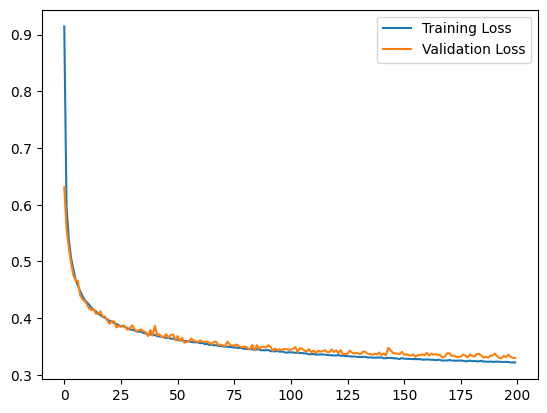

In [26]:
plt.plot(model.train_loss.data.cpu().numpy())
plt.plot(model.val_loss.data.cpu().numpy())
plt.legend(['Training Loss','Validation Loss'])

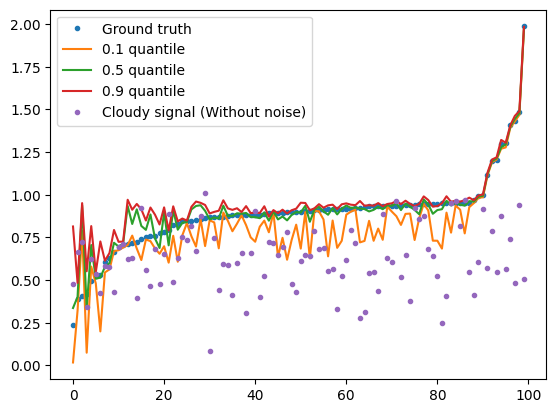

In [27]:
samples=100
channel=10

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]


plt.plot(y_plot_sort,'.')
plt.plot(y_pred_sort)
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','0.1 quantile', '0.5 quantile','0.9 quantile','Cloudy signal (Without noise)'])
plt.show()


/tmp/ipykernel_119947/2806638512.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x=np.linspace(0,samples,samples)


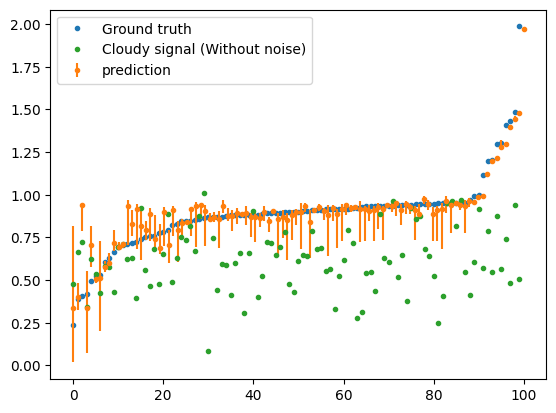

In [31]:
samples=100
channel=10

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]


plt.plot(y_plot_sort,'.')
plt.errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_sort[:,1],
             yerr=[np.abs(y_pred_sort[:,1]-y_pred_sort[:,0]),np.abs(y_pred_sort[:,1]-y_pred_sort[:,2])],
             marker='.',fmt='.')
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','Cloudy signal (Without noise)','prediction'])
plt.show()

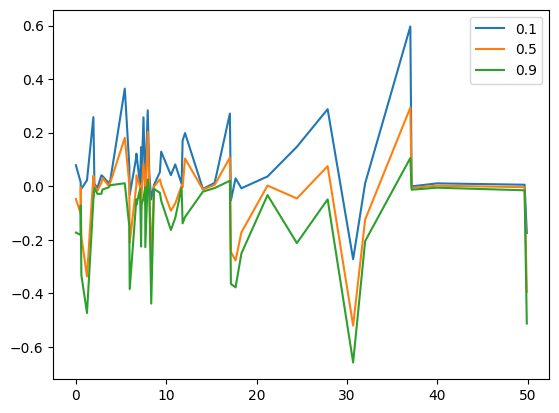

In [16]:
channel=11
samples=50

df_test=df.iloc[y_test.index]

#Get cot values
cot_column=df_test['COT'].to_numpy()
cot_column=cot_column[0:samples]
sort_ind=np.argsort(cot_column)
cot_column_sort=cot_column[sort_ind]

#Get ground truth
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

#Repeat ground truth to prepp difference
y_rep=np.repeat(y_plot_sort,len(quantiles),axis=0)
y_rep=np.reshape(y_rep,(-1,len(quantiles)))
diff=y_rep-y_pred_sort

#plt.plot(cot_column_sort,y_plot_sort,'.')
#plt.plot(cot_column_sort,y_pred_sort,'.')
plt.plot(cot_column_sort,diff)
plt.legend(['0.1','0.5','0.9'])

In [ ]:
hf.save_model_and_test_data(filepath='pytorch_models/'+str(nepochs)+'epochs',model=model,X_test=X_test,y_test=y_test)